# Texas Real Estate Investment Analyzer
**Week 4 Capstone Project**

## Problem Statement
Real estate investors spend hours manually comparing neighborhoods, calculating ROI metrics, and searching for listings that match their criteria. This tool automates that process - taking budget, strategy (cash flow vs appreciation), and location inputs to return ranked neighborhoods with example properties in seconds.

## Tool Purpose
- Help investors make data-driven decisions faster
- Provide clear ROI comparisons (LTR vs STR for cash flow, growth metrics for appreciation)
- Surface actionable listings in top-performing neighborhoods

## Approach
1. Load neighborhood home prices (Zillow ZHVI) + rental data (Zillow ZORI + Airbnb)
2. Calculate appreciation metrics (baseline CAGR, recovery trajectory, distance from peak)
3. Calculate cash flow metrics (STR/LTR income, monthly costs, net profit)
4. Filter by budget and rank by strategy
5. Return top 3 recommendations with supporting visualizations

## Data Sources
- **Zillow ZHVI:** 185 Austin neighborhoods, 2000-2025 home values
- **Zillow ZORI:** Long-term rental rates by neighborhood
- **Inside Airbnb:** 15,187 listings with occupancy and income data

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [3]:
# Load Zillow ZHVI data
df_home_values = pd.read_csv('../data/raw/zillow_zhvi_austin.csv')

# Explore structure
print("Dataset shape:", df_home_values.shape)
print("\n" + "="*50)
df_home_values.head()

Dataset shape: (895, 314)



,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30
0,102001,0,United States,country,NaN,123328.165417,123545.139196,123814.218630,124391.341197,125055.540080,125767.650802,126521.915537,127336.070915,128182.937049,129033.028662,129879.049429,130726.212923,131503.860487,132192.553266,132856.808358,133575.015806,134350.071383,135145.261752,135963.483531,136818.280548,137680.702974,138539.419698,139339.787970,140090.149100,140753.774955,141388.519329,142035.612681,142739.625135,143517.220238,144359.510310,145282.909005,146268.793246,147267.789851,148265.276426,149215.313181,150140.201911,150977.17

In [4]:
# Check data types and missing values
df_home_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Columns: 314 entries, RegionID to 2025-09-30
dtypes: float64(309), int64(2), object(3)
memory usage: 2.1+ MB


In [5]:
# Statistical summary
df_home_values.describe()

,RegionID,SizeRank,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30
count,895.000000,895.000000,431.000000,432.000000,433.000000,435.000000,437.000000,438.000000,439.000000,440.000000,441.000000,441.000000,444.000000,445.000000,453.000000,453.000000,453.000000,455.000000,456.000000,457.000000,458.000000,458.000000,458.000000,459.000000,460.000000,461.000000,462.000000,462.000000,462.000000,468.000000,471.000000,472.000000,472.000000,472.000000,471.000000,471.000000,470.000000,472.000000,474.000000,475.000000,477.000000,478.000000,480.000000,480.000000,484.000000,480.000000,480.000000,478.000000,488.000000,491.000000,495.000000,494.000000,495.

In [6]:
# Load Zillow ZORI data
df_rent = pd.read_csv('../data/raw/zillow_zori_austin.csv')

# Explore structure
print("Dataset shape:", df_rent.shape)
print("\n" + "="*50)
df_rent.head()

Dataset shape: (695, 134)



,RegionID,SizeRank,RegionName,RegionType,StateName,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30
0,102001,0,United States,country,NaN,1187.699708,1193.115753,1198.991436,1203.873957,1208.230005,1212.375541,1216.925956,1222.043841,1227.371030,1232.602488,1237.539006,1242.044749,1245.687254,1248.825897,1250.844299,1254.266127,1257.878684,1262.578442,1266.374633,1270.362790,1274.049119,1277.889974,1281.293473,1284.582468,1289.391953,1294.951861,1301.831218,1306.818727,1311.716605,1315.572034,1319.664314,1323.107967,1327.790875,1331.695924,1336.362078,1340.973372,1346.005334,1351.056500,1355.239672,1359.717229,1363.446617,1367.898302,1372.522532,1377.667810,1381.924837,1387.152312,1392.806681,1398.379994,1402.553826,1406.049089,1410.303135,1415.055081,1420.466246,1425.643595,1430.772685,1435.780368,1440.932748,1445.707166,1449.901447,1454.269676,1459.284531,1464.731227,1469.129306,1467.015791,1462.736256,1459.051955,1459.784037,1460.121635,1461.088191,1464.676028,1470.505498,1477.987739,1487.767862,1498.390762,1510.395060,1526.044557,1546.444009,1570.159225,1594.553516,1620.875238,1647.106858,1669.553640,1688.628520,1705.539751,1719.832878,1734.165010,1746.203849,1761.893773,1775.834787,1790.213603,1800.837157,1808.568303,1813.997279,1818.111131,1822.103620,1827.128594,1832.028464,1837.182145,1844.886669,1850.434783,1856.044141,1857.591175,1861.444268,1865.342411,1869.575817,1874.679559,1878.749115,1883.459757,1888.312211,1893.594285,1898.135376,1903.031749,1908.308718,1914.153115,1919.408896,1923.868888,1928.627985,1934.343097,1941.004429,1946.496370,1951.853488,1956.168289,1959.712829,1962.658726,1965.060633,1968.426621,1971.491682,1975.244718,1978.610962
1,394913,1,"New York, NY",msa,NY,2339.775516,2355.226733,2369.036436,2379.004985,2383.056204,2387.391302,2392.622804,2401.338930,2409.894440,2418.046348,2422.482283,2427.485438,2431.010071,2434.717760,2435.820966,2437.658733,2440.740747,2445.002423,2450.982743,2454.160492,2458.870980,2463.718017,2473.557196,2477.135750,2480.130954,2479.918674,2483.839014,2487.030048,2492.727152,2495.728727,2499.307524,2500.279406,2503.581574,2503.028546,2503.468365,2505.918231,2511.317753,2516.668436,2521.168290,2528.629061,2533.821297,2538.383839,2543.036297,2551.060165,2557.970458,2562.964665,2569.976254,2575.991426,2582.983071,2589.224520,2596.053305,2601.186545,2607.071350,2614.780735,2622.109882,2628.864107,2635.379382,2645.531831,2653.095713,2662.042462,2669.308600,2678.213606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2439.046082,2426.119319,2425.793228,2429.265666,2437.234343,2448.319643,2467.239626,2498.269357,2538.590193,2587.989249,2647.502208,2708.742

In [7]:
# Check data types and missing values
df_rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Columns: 134 entries, RegionID to 2025-09-30
dtypes: float64(129), int64(2), object(3)
memory usage: 727.7+ KB


In [8]:
# Statistical summary
df_rent.describe()

,RegionID,SizeRank,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30
count,695.000000,695.000000,212.000000,214.000000,217.000000,222.000000,222.000000,224.000000,223.000000,224.000000,225.000000,226.000000,227.000000,233.000000,236.000000,236.000000,239.000000,242.000000,256.000000,258.000000,260.000000,262.000000,262.000000,261.000000,262.000000,266.000000,269.000000,269.000000,269.000000,270.000000,271.000000,273.000000,275.000000,274.000000,277.000000,281.000000,282.000000,284.000000,285.000000,287.000000,288.000000,289.000000,293.000000,293.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,298.000000,298.000000,300.000000,301.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,301.000000,302.000000,302.000000,302.000000,300.000000,301.000000,303.000000,300.000000,298.000000,299.000000,302.000000,306.000000,308.000000,311.000000,317.000000,319.000000,324.000000,324.000000,328.000000,330.000000,332.000000,334.000000,337.000000,340.000000,345.000000,352.000000,371.000000,379.000000,386.000000,392.000000,402.000000,407.000000,410.000000,413.000000,415.000000,417.000000,424.000000,430.000000,440.000000,447.000000,455.000000,467.000000,484.000000,488.000000,490.000000,494.000000,493.000000,498.000000,503.000000,502.000000,511.000000,522.000000,522.000000,528.000000,534.000000,541.000000,550.000000,549.000000,553.000000,557.000000,563.000000,568.000000,587.000000,597.000000,606.000000,612.000000,627.000000,634.000000,642.000000,658.000000,695.000000
mean,415261.618705,371.435971,1021.334234,1024.919238,1028.089176,1027.078384,1030.422059,1031.299811,1035.201958,1039.560305,1042.225801,1046.147740,1051.250699,1051.877765,1052.953951,1055.938948,1063.523999,1069.194338,1058.835784,1061.921187,1064.044968,1068.464385,1071.857221,1076.324007,1077.767238,1076.370380,1078.921447,1085.174857,1088.510653,1093.060905,1095.439066,1094.745028,1096.506543,1101.208031,1102.148392,1100.546694,1110.651665,1113.132742,1115.817676,1119.500849,1122.346924,1124.981826,1127.005032,1131.412204,1134.602796,1139.392972,1143.107015,1147.527607,1151.850630,1156.406022,1162.151798,1165.790121,1171.249313,1173.785851,1177.739192,1181.849100,1186.585587,1190.793167,1195.101076,1198.848256,1199.155942,1206.609452,1211.545915,1215.963955,1216.178849,1213.358469,1212.974251,1203.681601,1204.871931,1210.140099,1225.804048,1242.451928,1253.647954,1262.220143,1266.854634,1274.278272,1283.458454,1296.437840,1310.919468,1324.180029,1343.786907,1359.568000,1373.814210,1387.026284,1394.052223,1397.668105,1403.962751,1409.484289,1417.814678,1427.548717,1435.106072,1441.248033,1444.

In [9]:
# Load Airbnb data
df_airbnb = pd.read_csv('../data/raw/airbnb_austin.csv.gz')

# Explore structure
print("Dataset shape:", df_airbnb.shape)
print("\n" + "="*50)
df_airbnb.head()

Dataset shape: (15187, 79)



,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5456,https://www.airbnb.com/rooms/5456,20250613040113,2025-06-13,city scrape,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,https://www.airbnb.com/users/show/8028,Sylvia,2009-02-16,"Austin, TX",I am a licensed Real Estate Broker and owner o...,within a few hours,100%,92%,t,https://a0.muscache.com/im/users/8028/profile_...,https://a0.muscache.com/im/users/8028/profile_...,East Downtown,1.0,2.0,"['email', 'phone']",t,t,Neighborhood highlights,78702,NaN,30.26057,-97.73441,Entire guesthouse,Entire home/apt,3,1.0,1 bath,1.0,2.0,"[""Extra pillows and blankets"", ""Wifi"", ""Luggag...",$101.00,2,90,2,2,90,90,2.0,90.0,NaN,t,30,60,90,336,2025-06-13,711,27,0,185,33,162,16362.0,2009-03-08,2025-04-27,4.85,4.88,4.86,4.90,4.82,4.73,4.79,NaN,f,1,1,0,0,3.59
1,5769,https://www.airbnb.com/rooms/5769,20250613040113,2025-06-13,city scrape,NW Austin Room,NaN,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186,Elizabeth,2009-02-19,"Austin, TX",We're easygoing professionals that enjoy meeti...,within an hour,100%,100%,f,https://a0.muscache.com/im/users/8186/profile_...,https://a0.muscache.com/im/users/8186/profile_...,SW Williamson Co.,1.0,4.0,"['email', 'phone', 'work_email']",t,t,Neighborhood highlights,78729,NaN,30.45697,-97.78422,Private room in home,Private room,2,1.0,1 shared bath,1.0,1.0,"[""Extra pillows and blankets"", ""Wifi"", ""Hair d...",$45.00,1,14,1,1,14,14,1.0,14.0,NaN,t,4,4,4,4,2025-06-13,304,5,3,4,5,30,1350.0,2010-04-10,2025-06-08,4.91,4.91,4.87,4.91,4.94,4.77,4.92,NaN,f,1,0,1,0,1.65
2,6413,https://www.airbnb.com/rooms/6413,20250613040113,2025-06-14,previous scrape,Gem of a Studio near Downtown,"Great studio apartment, perfect a single perso...",Travis Heights is one of the oldest neighborho...,https://a0.muscache.com/pictures/hosting/Hosti...,13879,https://www.airbnb.com/users/show/13879,Todd,2009-04-17,"Austin, TX","We're a young family that likes to travel, we ...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/4f35e...,https://a0.muscache.com/im/pictures/user/4f35e...,Travis Heights,1.0,1.0,"['email', 'phone']",t,t,Neighborhood highlights,78704,NaN,30.24885,-97.73587,Entire guesthouse,Entire home/apt,2,NaN,1 bath,NaN,NaN,"[""37 inch HDTV with Amazon Prime Video, Apple ...",NaN,30,90,30,30,90,90,30.0,90.0,NaN,t,0,0,0,0,2025-06-14,123,3,0,0,2,180,NaN,2009-12-14,2025-03-12,4.98,4.99,4

In [10]:
# Check data types and missing values
df_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15187 entries, 0 to 15186
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            15187 non-null  int64  
 1   listing_url                                   15187 non-null  object 
 2   scrape_id                                     15187 non-null  int64  
 3   last_scraped                                  15187 non-null  object 
 4   source                                        15187 non-null  object 
 5   name                                          15187 non-null  object 
 6   description                                   14840 non-null  object 
 7   neighborhood_overview                         7914 non-null   object 
 8   picture_url                                   15186 non-null  object 
 9   host_id                                       15187 non-null 

In [11]:
# Statistical summary (numeric columns only)
df_airbnb.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,1.518700e+04,1.518700e+04,1.518700e+04,15185.000000,15185.000000,15187.000000,0.0,15187.000000,15187.000000,15187.000000,10714.000000,14248.000000,10696.000000,15187.000000,15187.000000,15187.000000,15187.000000,1.518700e+04,1.518700e+04,15187.00000,1.518700e+04,0.0,15187.000000,15187.000000,15187.000000,15187.000000,15187.000000,15187.000000,15187.000000,15187.000000,15187.000000,15187.000000,1.070800e+04,12276.000000,12276.000000,12276.000000,12275.000000,12276.000000,12274.000000,12274.000000,0.0,15187.000000,15187.000000,15187.000000,15187.000000,12276.000000
mean,5.995245e+17,2.025061e+13,1.817908e+08,120.095357,183.402305,78724.375979,NaN,30.280347,-97.750361,5.008560,1.738380,2.095101,2.972046,7.888984,461.863172,7.339698,10.869362,1.273240e+06,5.798163e+06,8.31683,5.785746e+06,NaN,12.489629,28.745045,46.358267,174.443010,44.177454,9.756305,0.708369,104.304208,9.278528,62.136037,1.518667e+04,4.832434,4.851587,4.807500,4.893805,4.897551,4.820204,4.772874,NaN,9.715480,7.181405,1.271350,0.376045,1.455868
std,5.520278e+17,7.531498e+00,2.008631e+08,575.928485,858.930696,20.806128,NaN,0.064183,0.064474,3.426457,1.046643,1.441938,2.981831,30.206797,432.045884,30.122596,40.731182,5.226375e+07,1.114328e+08,30.56368,1.111946e+08,NaN,11.731817,24.151031,36.233886,140.900826,91.255975,16.743168,1.487853,79.538377,16.882992,82.424938,5.245284e+04,0.343546,0.338384,0.362994,0.296193,0.301599,0.323714,0.370725,NaN,20.144832,16.730664,5.491494,4.706305,1.681180
min,5.456000e+03,2.025061e+13,2.300000e+01,1.000000,1.000000,78701.000000,NaN,30.078440,-98.053350,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.00000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,3.215426e+07,2.025061e+13,1.849321e+07,1.000000,1.000000,78704.000000,NaN,30.241905,-97.768320,2.000000,1.000000,1.000000,1.000000,1.000000,60.000000,1.000000,2.000000,9.900000e+01,3.600000e+02,1.30000,1.800000e+02,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.020000e+02,4.800000,4.840000,4.770000,4.900000,4.910000,4.780000,4.730000,NaN,1.000000,1.000000,0.000000,0.000000,0.230000
50%,6.973160e+17,2.025061e+13,8.476714e+07,2.000000,3.000000,78723.000000,NaN,30.269239,-97.741428,4.000000,1.000000,2.000000,2.000000,2.000000,365.000000,2.000000,3.000000,3.650000e+02,3.650000e+02,2.00000,3.650000e+02,NaN,12.000000,33.000000,57.000000,177.000000,10.000000,2.000000,0.000000,127.000000,1.000000,18.000000,7.077000e+03,4.940000,4.950000,4.920000,4.980000,4.990000,4.910000,4.860000,NaN,2.000000,1.000000,0.000000,0.000000,0.900000
75%,1.128970e+18,2.025061e+13,3.327081e+08,11.000000,15.000000,78745.000000,NaN,30.309210,-97.716984,6.000000,2.000000,3.000000,4.000000,3.000000,1125.000000,3.000000,4.000000,1.125000e+03,1.125000e+03,3.00000,1.125000e+03,NaN,24.000000,53.000000,81.000000,323.000

## Initial Data Observations

### Home Values Dataset (ZHVI):
- Shape: 895 rows × 314 columns
- Time range: 2000-01-31 to 2025-09-30
- **Issue:** Includes all metros nationwide, not just Austin
- **Solution:** Filter by RegionName containing "Austin"
- Data structure: Each column is a date (time series), each row is a region

### Rental Rates Dataset (ZORI):
- Shape: 695 rows × 134 columns
- Time range: 2015-01-31 to 2025-09-30
- **Issue:** Same as ZHVI - includes all metros
- **Solution:** Filter by RegionName containing "Austin"
- Data structure: Same time-series format as ZHVI

### Airbnb Dataset:
- Shape: 15,187 rows × 79 columns
- Key columns: price, bedrooms, host_neighbourhood, property_type, availability_365, estimated_occupancy_l365d
- **Issue:** Need to verify column names and data formats
- **Good news:** Already Austin-specific (no filtering needed)
- Data structure: Each row is one Airbnb listing

## Data Cleaning & Filtering

**Goal:** Prepare datasets for analysis by:
1. Filtering to Austin metro only (Zillow includes all US metros)
2. Standardizing neighborhood names for merging
3. Removing neighborhoods with insufficient data (<10 Airbnb listings)


In [12]:
# Filter ZHVI data to Austin metro only
# Look for "Austin" in RegionName column
df_home_values_austin = df_home_values[df_home_values['RegionName'].str.contains('Austin', case=False, na=False)]

print("Filtered to Austin metro:")
print(f"Original shape: {df_home_values.shape}")
print(f"Austin only: {df_home_values_austin.shape}")
print("\n" + "="*50)
df_home_values_austin.head()

Filtered to Austin metro:
Original shape: (895, 314)
Austin only: (2, 314)



,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30
29,394355,29,"Austin, TX",msa,TX,172877.545503,173446.017259,173966.530023,174794.113759,175419.076996,175697.682638,175805.893359,176420.831675,177094.863020,178154.813766,178855.448249,179446.419791,179648.674738,179664.313772,179988.647553,180622.853515,181184.273068,181557.543792,181742.161266,182005.980507,182068.916845,182079.283103,182057.650213,181915.318738,181869.126685,181531.268224,181379.884476,181172.499072,181020.328338,180779.463546,180441.144496,180254.602982,180320.697062,180339.092050,180279.490798,179894.178158,179577.995586

In [13]:
# Filter ZORI data to Austin metro only
df_rent_austin = df_rent[df_rent['RegionName'].str.contains('Austin', case=False, na=False)]

print("Filtered to Austin metro:")
print(f"Original shape: {df_rent.shape}")
print(f"Austin only: {df_rent_austin.shape}")
print("\n" + "="*50)
df_rent_austin.head()

Filtered to Austin metro:
Original shape: (695, 134)
Austin only: (2, 134)



,RegionID,SizeRank,RegionName,RegionType,StateName,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30
29,394355,29,"Austin, TX",msa,TX,1166.697664,1174.338507,1176.142024,1176.753047,1179.730347,1185.216652,1191.692343,1199.412353,1205.015639,1211.30402,1216.100367,1221.960218,1224.401922,1223.48595,1221.669888,1224.657723,1227.810097,1232.350675,1235.503166,1238.25015,1240.360543,1241.111093,1241.925273,1244.684315,1249.345756,1255.33244,1262.870623,1266.453917,1268.253516,1268.761204,1267.737935,1266.212241,1265.647709,1267.146672,1272.305978,1275.018912,1276.38777,1281.121992,1282.25931,1287.355417,1290.339846,1297.612479,1303.599966,1309.498064,1314.837301,1320.941572,1328.858459,1332.934882,1336.980748,1340.45365,1346.094556,1349.779841,1356.076265,1359.380855,1364.837755,1370.759433,1376.9426,1381.818836,1383.553727,1389.213714,1395.4162,1400.307953,1405.0708,1398.102402,1387.131727,1375.08334,1369.083031,1366.441846,1364.054655,1367.529425,1376.327571,1386.718682,1400.618091,1413.764046,1429.350221,1451.68893,1482.768015,1519.889855,1558.062633,1599.110187,1635.367402,1660.168482,1674.099389,1688.278111,1698.051019,1712.711538,1722.633642,1739.181883,1750.577592,1763.501878,1771.404266,1770.91499,1768.986188,1763.747728,1759.089001,1755.037392,1755.169617,1755.748563,1760.291872,1754.444382,1749.084387,1736.806446,1729.111469,1720.944545,1712.517800,1709.862549,1708.735768,1707.000472,1701.555173,1693.936661,1686.142855,1681.732528,1677.434477,1674.517877,1669.964389,1664.361515,1660.615584,1657.036947,1653.180882,1648.669748,1645.043154,1641.334329,1636.326254,1631.533403,1626.781916,1623.306056,1619.676426,1618.147229,1615.505199
622,394354,698,"Austin, MN",msa,MN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725.495037,731.068611,736.437061,727.938581,735.852126,748.396583,764.499861,773.353765,768.206652,788.142038,796.923810,811.233769,797.066494,792.984294,800.791523,818.014834,832.567968,841.485367,843.017446,848.534649,849.652999,844.523140,850.098723,NaN,880.028048,892.798545,896.202811,897.347662,893.783189,895.884088,903.492677,911.675112,925.916667


In [14]:
# Inspect key Airbnb columns
airbnb_key_cols = ['id', 'name', 'host_neighbourhood', 'neighbourhood_cleansed', 
                   'property_type', 'price', 'bedrooms', 'beds', 'availability_365', 
                   'number_of_reviews', 'reviews_per_month']

# Check if these columns exist
existing_cols = [col for col in airbnb_key_cols if col in df_airbnb.columns]
print("Key columns available:")
print(existing_cols)
print("\n" + "="*50)

# Display sample
df_airbnb[existing_cols].head(10)

Key columns available:
['id', 'name', 'host_neighbourhood', 'neighbourhood_cleansed', 'property_type', 'price', 'bedrooms', 'beds', 'availability_365', 'number_of_reviews', 'reviews_per_month']



,id,name,host_neighbourhood,neighbourhood_cleansed,property_type,price,bedrooms,beds,availability_365,number_of_reviews,reviews_per_month
0,5456,"Walk to 6th, Rainey St and Convention Ctr",East Downtown,78702,Entire guesthouse,$101.00,1.0,2.0,336,711,3.59
1,5769,NW Austin Room,SW Williamson Co.,78729,Private room in home,$45.00,1.0,1.0,4,304,1.65
2,6413,Gem of a Studio near Downtown,Travis Heights,78704,Entire guesthouse,NaN,NaN,NaN,0,123,0.65
3,6448,"Secluded Studio @ Zilker - King Bed, Bright & ...",Zilker,78704,Entire guesthouse,$155.00,1.0,2.0,312,338,2.02
4,8502,Woodland Studio Lodging,East Riverside,78741,Entire guest suite,$43.00,1.0,1.0,98,54,0.29
5,13035,Historic house in highly walkable East Austin,East Downtown,78702,Entire home,$145.00,2.0,2.0,301,18,0.10
6,22828,Garage Apartment central SE Austin,East Riverside,78741,Entire guesthouse,$58.00,1.0,1.0,301,55,0.30
7,27632,Clarksville Condo - Weekly Rentals Only!,Old West Austin,78703,Entire condo,$95.00,1.0,1.0,294,99,0.55
8,40285,"OUTDOOR LIVING IN AUSTIN, TX",Northwest Hills,78731,Entire home,$514.00,2.0,2.0,315,42,0.24
9,47572,Cozy Private Room in North Austin for Longer S...,NaN,78758,Private room in home,$72.00,1.0,1.0,224,9,0.12


In [15]:
# Check if estimated_occupancy column exists
if 'estimated_occupancy_l365d' in df_airbnb.columns:
    print("✓ Estimated occupancy column found!")
    print("\nSample occupancy values:")
    print(df_airbnb['estimated_occupancy_l365d'].describe())
else:
    print("✗ Need to estimate occupancy from reviews_per_month")

✓ Estimated occupancy column found!

Sample occupancy values:
count    15187.000000
mean        62.136037
std         82.424938
min          0.000000
25%          0.000000
50%         18.000000
75%        108.000000
max        255.000000
Name: estimated_occupancy_l365d, dtype: float64


In [16]:
df_zillow_neighborhoods = pd.read_csv('../data/raw/zillow_zhvi_neighborhoods_national.csv')

# Filter to Austin metro neighborhoods
df_austin_neighborhoods = df_zillow_neighborhoods[df_zillow_neighborhoods['Metro'].str.contains('Austin', case=False, na=False)].copy()

print(f"Austin neighborhoods found: {len(df_austin_neighborhoods)}")
df_austin_neighborhoods[['RegionName', 'City', 'State']].head(20)

Austin neighborhoods found: 185


,RegionName,City,State
479,North Austin,Austin,TX
730,West Oak Hill,Austin,TX
793,Jollyville,Austin,TX
941,Windsor Park,Austin,TX
954,East Oak Hill,Austin,TX
1028,West University,Austin,TX
1097,Pleasant Valley,Austin,TX
1144,Franklin Park,Austin,TX
1368,Downtown,Austin,TX
1446,Riverside,Austin,TX


In [17]:
# Check what columns we have
print("Columns available:")
print(df_austin_neighborhoods.columns.tolist())

# Check time range
date_columns = [col for col in df_austin_neighborhoods.columns if col.startswith('20')]
print(f"\nTime range: {date_columns[0]} to {date_columns[-1]}")
print(f"Total months: {len(date_columns)}")

# Check for missing values in recent data
print("\nMissing values in Sept 2025:")
print(df_austin_neighborhoods['2025-09-30'].isna().sum())

Columns available:
['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName', '2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31', '2000-09-30', '2000-10-31', '2000-11-30', '2000-12-31', '2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30', '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31', '2001-09-30', '2001-10-31', '2001-11-30', '2001-12-31', '2002-01-31', '2002-02-28', '2002-03-31', '2002-04-30', '2002-05-31', '2002-06-30', '2002-07-31', '2002-08-31', '2002-09-30', '2002-10-31', '2002-11-30', '2002-12-31', '2003-01-31', '2003-02-28', '2003-03-31', '2003-04-30', '2003-05-31', '2003-06-30', '2003-07-31', '2003-08-31', '2003-09-30', '2003-10-31', '2003-11-30', '2003-12-31', '2004-01-31', '2004-02-29', '2004-03-31', '2004-04-30', '2004-05-31', '2004-06-30', '2004-07-31', '2004-08-31', '2004-09-30', '2004-10-31', '2004-11-30', '2004-12-31', '2005-01-31', '2005-02-28', '2005-0

In [18]:
# Get current prices (Sept 2025) for each neighborhood
df_austin_neighborhoods['current_price_2025'] = df_austin_neighborhoods['2025-09-30']

# Get peak price (find max across 2022 columns)
peak_cols = [col for col in df_austin_neighborhoods.columns if col.startswith('2022')]
df_austin_neighborhoods['peak_price_2022'] = df_austin_neighborhoods[peak_cols].max(axis=1)

# Get pre-pandemic baseline (average of 2015-2019)
baseline_cols = [col for col in df_austin_neighborhoods.columns 
                 if '2015' in col or '2016' in col or '2017' in col or '2018' in col or '2019' in col]
df_austin_neighborhoods['baseline_price_2015_2019'] = df_austin_neighborhoods[baseline_cols].mean(axis=1)

# Display summary
print("Price Summary:")
print(df_austin_neighborhoods[['RegionName', 'baseline_price_2015_2019', 'peak_price_2022', 'current_price_2025']].head(10))

Price Summary:
           RegionName  baseline_price_2015_2019  peak_price_2022  \
479      North Austin             229105.449090    473143.572750   
730     West Oak Hill             384056.110091    750091.130881   
793        Jollyville             279940.139203    561026.170890   
941      Windsor Park             353271.325325    644481.064347   
954     East Oak Hill             434945.146316    837738.558850   
1028  West University             257155.040361    372196.172110   
1097  Pleasant Valley             199141.756547    385708.994381   
1144    Franklin Park             182423.507543    403009.359470   
1368         Downtown             564958.847918    864508.527350   
1446        Riverside             304347.844693    600817.238049   

      current_price_2025  
479        355157.917570  
730        591620.958501  
793        437978.278122  
941        450649.412230  
954        670860.099100  
1028       314777.289298  
1097       266291.354847  
1144       268219.76

## Appreciation Strategy Analysis

**Metrics to Calculate:**
- **Baseline CAGR (2015-2019):** "Normal" appreciation rate before pandemic distortion
- **Recovery CAGR (2023-2025):** Current momentum (is the market recovering?)
- **Distance from Peak:** How far below 2022 peak prices (shows upside potential)

**Why these periods?**
- 2015-2019: Stable growth, representative of long-term fundamentals
- 2020-2022: Excluded (pandemic spike, not sustainable)
- 2023-2025: Post-correction recovery phase


In [19]:
# Calculate pre-pandemic CAGR (2015-2019)
df_austin_neighborhoods['baseline_cagr'] = (
    (df_austin_neighborhoods['2019-12-31'] / df_austin_neighborhoods['2015-01-31']) ** (1/5) - 1
) * 100

# Calculate current recovery trajectory (2023-2025)
df_austin_neighborhoods['recovery_cagr'] = (
    (df_austin_neighborhoods['2025-09-30'] / df_austin_neighborhoods['2023-01-31']) ** (1/2.75) - 1
) * 100

# Distance from peak
df_austin_neighborhoods['distance_from_peak'] = (
    (df_austin_neighborhoods['current_price_2025'] / df_austin_neighborhoods['peak_price_2022']) - 1
) * 100

# Display
print("Appreciation Metrics:")
print(df_austin_neighborhoods[['RegionName', 'baseline_cagr', 'recovery_cagr', 'distance_from_peak']].head(10))

Appreciation Metrics:
           RegionName  baseline_cagr  recovery_cagr  distance_from_peak
479      North Austin      11.343479      -6.630867          -24.936544
730     West Oak Hill       5.028664      -4.405938          -21.126789
793        Jollyville       6.123306      -4.609449          -21.932648
941      Windsor Park       6.195825      -8.468050          -30.075616
954     East Oak Hill       5.534263      -3.780243          -19.920112
1028  West University       5.105116      -3.234956          -15.427048
1097  Pleasant Valley       7.693813      -9.523908          -30.960553
1144    Franklin Park      10.468946      -9.956678          -33.445774
1368         Downtown       2.212645      -7.413039          -24.441047
1446        Riverside       9.645236      -7.306314          -25.771504


In [20]:
# Clean price column (remove $ and convert to float)
df_airbnb['price_clean'] = df_airbnb['price'].replace('[\$,]', '', regex=True).astype(float)

# Calculate monthly STR income
df_airbnb['monthly_str_income'] = df_airbnb['price_clean'] * 30 * (df_airbnb['estimated_occupancy_l365d'] / 100)

# Group by neighborhood
airbnb_by_neighborhood = df_airbnb.groupby('host_neighbourhood').agg({
    'price_clean': 'median',
    'monthly_str_income': 'median',
    'bedrooms': 'median',
    'id': 'count'  # number of listings
}).reset_index()

airbnb_by_neighborhood.columns = ['neighborhood', 'median_nightly_rate', 'median_monthly_str_income', 'median_bedrooms', 'listing_count']

print(f"Airbnb neighborhoods: {len(airbnb_by_neighborhood)}")
print(airbnb_by_neighborhood.head(10))

Airbnb neighborhoods: 733
               neighborhood  median_nightly_rate  median_monthly_str_income  \
0       Academy Acres North                416.0                    15724.8   
1                Acres Home                348.5                      513.0   
2                 Allandale                179.0                     3186.0   
3                 Allendale                 96.0                     1965.6   
4             Alphabet City                  NaN                        NaN   
5                 Alta Mira                118.5                       74.7   
6  American University Park                  NaN                        NaN   
7                   Anaheim                  NaN                        NaN   
8            Anaheim Resort                350.0                     1431.0   
9                 Anastasia                174.0                      313.2   

   median_bedrooms  listing_count  
0              3.0              1  
1              3.5              

In [21]:
# Get unique neighborhood names from each dataset
zillow_neighborhoods = set(df_austin_neighborhoods['RegionName'].str.lower().str.strip())
airbnb_neighborhoods = set(airbnb_by_neighborhood['neighborhood'].dropna().str.lower().str.strip())

# Check overlap
overlap = zillow_neighborhoods & airbnb_neighborhoods
print(f"Zillow neighborhoods: {len(zillow_neighborhoods)}")
print(f"Airbnb neighborhoods: {len(airbnb_neighborhoods)}")
print(f"Overlap: {len(overlap)}")

# Show samples
print("\nZillow samples:", list(zillow_neighborhoods)[:10])
print("\nAirbnb samples:", list(airbnb_neighborhoods)[:10])
print("\nOverlapping samples:", list(overlap)[:10])

Zillow neighborhoods: 184
Airbnb neighborhoods: 732
Overlap: 75

Zillow samples: ['parkside at mayfield ranch', 'northtown park', 'wells branch', 'rosedale', 'spring trails', 'cat hollow', 'mlk 183', 'crestview', 'bryker woods', 'fountainwood estates']

Airbnb samples: ['mid-beach', 'mission valley east', 'the woods of greenshores', 'north shields', 'rosedale', 'copacabana', 'crestview', 'spice forest', 'bryker woods', 'riverplace']

Overlapping samples: ['allandale', 'north burnet', 'northtown park', 'wells point', 'heritage', 'rosedale', 'mountain creek', 'crestview', 'bryker woods', 'east cesar chavez']


In [22]:
# Standardize neighborhood names for merging (lowercase, strip whitespace)
df_austin_neighborhoods['neighborhood_clean'] = df_austin_neighborhoods['RegionName'].str.lower().str.strip()
airbnb_by_neighborhood['neighborhood_clean'] = airbnb_by_neighborhood['neighborhood'].str.lower().str.strip()

# Merge on cleaned neighborhood names
df_merged = df_austin_neighborhoods.merge(
    airbnb_by_neighborhood,
    on='neighborhood_clean',
    how='inner'  # Only keep neighborhoods that exist in BOTH datasets
)

print(f"Merged neighborhoods: {len(df_merged)}")
print("\nMerged data preview:")
print(df_merged[['RegionName', 'current_price_2025', 'median_monthly_str_income', 'baseline_cagr', 'listing_count']].head(10))

Merged neighborhoods: 75

Merged data preview:
        RegionName  current_price_2025  median_monthly_str_income  \
0     North Austin       355157.917570                     7560.0   
1    West Oak Hill       591620.958501                     2700.0   
2     Windsor Park       450649.412230                     2019.6   
3  Pleasant Valley       266291.354847                      244.8   
4    Franklin Park       268219.760607                     2030.4   
5         Downtown       653213.588039                     5918.4   
6        Riverside       445977.598660                      522.0   
7        Allandale       769001.814422                     3186.0   
8       Montopolis       325038.409478                     2142.0   
9     North Burnet       224167.839549                     2160.0   

   baseline_cagr  listing_count  
0      11.343479              2  
1       5.028664             61  
2       6.195825            173  
3       7.693813             39  
4      10.468946       

## Cash Flow Strategy Analysis

**Assumptions (Conservative):**
- 20% down payment
- 7% interest rate (30-year fixed)
- Property taxes: 1.2% annually (Texas average)
- Insurance: 0.5% annually
- Maintenance: 1% annually

**Income Estimates:**
- **STR (Short-Term Rental):** Based on actual Airbnb data (nightly rate × occupancy)
- **LTR (Long-Term Rental):** Industry rule: STR income ÷ 2.5

**Formula:**
Monthly Cash Flow = Monthly Income - (Mortgage + Taxes + Insurance + Maintenance)


In [23]:
# Estimate LTR monthly rent (industry rule: STR income / 2.5)
df_merged['estimated_ltr_monthly_rent'] = df_merged['median_monthly_str_income'] / 2.5

# Calculate rent-to-price ratios
df_merged['str_rent_to_price_ratio'] = (df_merged['median_monthly_str_income'] * 12 / df_merged['current_price_2025']) * 100
df_merged['ltr_rent_to_price_ratio'] = (df_merged['estimated_ltr_monthly_rent'] * 12 / df_merged['current_price_2025']) * 100

# Calculate monthly cash flow (simplified - assumes 20% down, 7% interest, 1.2% tax, 0.5% insurance, 1% maintenance)
# Monthly payment = (80% of price) * 0.007 (monthly rate) / (1 - (1 + 0.007)^-360) + taxes + insurance + maintenance
loan_amount = df_merged['current_price_2025'] * 0.8
monthly_interest_rate = 0.07 / 12
n_payments = 360
monthly_mortgage = loan_amount * (monthly_interest_rate * (1 + monthly_interest_rate)**n_payments) / ((1 + monthly_interest_rate)**n_payments - 1)
monthly_taxes = df_merged['current_price_2025'] * 0.012 / 12
monthly_insurance = df_merged['current_price_2025'] * 0.005 / 12
monthly_maintenance = df_merged['current_price_2025'] * 0.01 / 12

df_merged['monthly_costs'] = monthly_mortgage + monthly_taxes + monthly_insurance + monthly_maintenance
df_merged['str_monthly_cash_flow'] = df_merged['median_monthly_str_income'] - df_merged['monthly_costs']
df_merged['ltr_monthly_cash_flow'] = df_merged['estimated_ltr_monthly_rent'] - df_merged['monthly_costs']

print("Cash Flow Analysis:")
print(df_merged[['RegionName', 'current_price_2025', 'str_monthly_cash_flow', 'ltr_monthly_cash_flow']].head(10))

Cash Flow Analysis:
        RegionName  current_price_2025  str_monthly_cash_flow  \
0     North Austin       355157.917570            4870.595096   
1    West Oak Hill       591620.958501           -1780.002356   
2     Windsor Park       450649.412230           -1392.906605   
3  Pleasant Valley       266291.354847           -1771.669971   
4    Franklin Park       268219.760607              -0.672669   
5         Downtown       653213.588039             971.992387   
6        Riverside       445977.598660           -2855.129670   
7        Allandale       769001.814422           -2637.204690   
8       Montopolis       325038.409478            -319.327340   
9     North Burnet       224167.839549             462.506977   

   ltr_monthly_cash_flow  
0             334.595096  
1           -3400.002356  
2           -2604.666605  
3           -1918.549971  
4           -1218.912669  
5           -2579.047613  
6           -3168.329670  
7           -4548.804690  
8           -1604.527

In [24]:
# Check distribution of listing counts
print("Listing count distribution:")
print(df_merged['listing_count'].describe())
print(f"\nNeighborhoods with <10 listings: {len(df_merged[df_merged['listing_count'] < 10])}")
print(f"Neighborhoods with 10+ listings: {len(df_merged[df_merged['listing_count'] >= 10])}")

# Show neighborhoods with few listings (less reliable STR estimates)
print("\nNeighborhoods with <10 Airbnb listings (less reliable):")
print(df_merged[df_merged['listing_count'] < 10][['RegionName', 'listing_count', 'median_monthly_str_income']].sort_values('listing_count'))

Listing count distribution:
count     75.000000
mean      74.120000
std       86.431188
min        1.000000
25%        9.500000
50%       39.000000
75%      113.000000
max      407.000000
Name: listing_count, dtype: float64

Neighborhoods with <10 listings: 19
Neighborhoods with 10+ listings: 56

Neighborhoods with <10 Airbnb listings (less reliable):
                  RegionName  listing_count  median_monthly_str_income
68                 Rio Vista              1                        NaN
65            Mountain Creek              1                    15820.2
46                    Sonoma              1                    13500.0
59              Windsor Road              1                      960.0
0               North Austin              2                     7560.0
6                  Riverside              2                      522.0
66            Northtown Park              2                     1288.8
64                  Heritage              2                     3367.8
60     

In [25]:
# Keep only neighborhoods with 10+ Airbnb listings for reliable STR estimates
df_final = df_merged[df_merged['listing_count'] >= 10].copy()

print(f"Final dataset: {len(df_final)} neighborhoods with reliable data")
print("\nFinal data summary:")
print(df_final[['RegionName', 'current_price_2025', 'str_monthly_cash_flow', 'baseline_cagr', 'listing_count']].describe())

Final dataset: 56 neighborhoods with reliable data

Final data summary:
       current_price_2025  str_monthly_cash_flow  baseline_cagr  listing_count
count        5.600000e+01              56.000000      56.000000      56.000000
mean         5.693256e+05           -1999.525108       6.626428      98.000000
std          3.064154e+05            2831.478527       2.360618      88.071046
min          2.241678e+05          -15841.967681       1.590534      10.000000
25%          3.724402e+05           -2739.929460       4.979282      29.000000
50%          5.416890e+05           -1744.872150       6.226357      72.500000
75%          6.422754e+05            -615.187510       7.725070     139.250000
max          2.180725e+06            5070.504484      11.830551     407.000000


In [26]:
# CASH FLOW STRATEGY: Rank by STR monthly cash flow (descending)
df_cash_flow_ranked = df_final.sort_values('str_monthly_cash_flow', ascending=False).copy()

print("="*70)
print("TOP 10 NEIGHBORHOODS - CASH FLOW STRATEGY (STR)")
print("="*70)
print(df_cash_flow_ranked[['RegionName', 'current_price_2025', 'str_monthly_cash_flow', 
                            'ltr_monthly_cash_flow', 'str_rent_to_price_ratio', 'listing_count']].head(10))

print("\n" + "="*70)
print("TOP 10 NEIGHBORHOODS - APPRECIATION STRATEGY")
print("="*70)

# APPRECIATION STRATEGY: Rank by baseline CAGR (descending)
df_appreciation_ranked = df_final.sort_values('baseline_cagr', ascending=False).copy()
print(df_appreciation_ranked[['RegionName', 'current_price_2025', 'baseline_cagr', 
                              'recovery_cagr', 'distance_from_peak']].head(10))

TOP 10 NEIGHBORHOODS - CASH FLOW STRATEGY (STR)
           RegionName  current_price_2025  str_monthly_cash_flow  \
50     Coronado Hills       308315.641181            5070.504484   
5            Downtown       653213.588039             971.992387   
20        North Lamar       292251.581727             855.798289   
15     Georgian Acres       291676.847929             712.700414   
33  Upper Boggy Creek       575312.628599             633.091167   
9        North Burnet       224167.839549             462.506977   
54              Holly       573923.421813             442.010824   
14        Parker Lane       345078.742164             194.918845   
4       Franklin Park       268219.760607              -0.672669   
18             Wooten       420082.964771            -135.444628   

    ltr_monthly_cash_flow  str_rent_to_price_ratio  listing_count  
50             627.384484                28.821892             26  
5            -2579.047613                10.872523            181  

## Recommendation Engine

**User Inputs:**
1. Budget range (min/max)
2. Strategy (Cash Flow or Appreciation)
3. Rental type (STR or LTR, if Cash Flow strategy)

**Process:**
1. Filter neighborhoods by budget
2. Rank by appropriate metric:
   - Cash Flow → Sort by monthly profit (descending)
   - Appreciation → Sort by baseline CAGR (descending)
3. Return top 3 with detailed stats


In [27]:
# ============================================================================
# USER INPUT SECTION
# ============================================================================

# For MVP, we'll hardcode example inputs (later: Streamlit form)

# Example Investor Profile
user_budget_min = 250000
user_budget_max = 400000
user_strategy = "Cash Flow"  # Options: "Cash Flow" or "Appreciation"
user_rental_type = "STR"  # Options: "STR" or "LTR" (only matters for Cash Flow strategy)

print("="*70)
print("TEXAS REAL ESTATE INVESTMENT ANALYZER")
print("="*70)
print(f"\nInvestor Profile:")
print(f"  Budget: ${user_budget_min:,} - ${user_budget_max:,}")
print(f"  Strategy: {user_strategy}")
if user_strategy == "Cash Flow":
    print(f"  Rental Type: {user_rental_type}")

TEXAS REAL ESTATE INVESTMENT ANALYZER

Investor Profile:
  Budget: $250,000 - $400,000
  Strategy: Cash Flow
  Rental Type: STR


In [28]:
# Filter by budget
df_budget_filtered = df_final[
    (df_final['current_price_2025'] >= user_budget_min) & 
    (df_final['current_price_2025'] <= user_budget_max)
].copy()

print(f"\nNeighborhoods matching budget: {len(df_budget_filtered)}")

if len(df_budget_filtered) == 0:
    print("\n⚠️ No neighborhoods found in this price range. Try adjusting your budget.")
else:
    # Rank based on strategy
    if user_strategy == "Cash Flow":
        if user_rental_type == "STR":
            df_recommended = df_budget_filtered.sort_values('str_monthly_cash_flow', ascending=False).head(3)
            metric_col = 'str_monthly_cash_flow'
            metric_name = "STR Monthly Cash Flow"
        else:  # LTR
            df_recommended = df_budget_filtered.sort_values('ltr_monthly_cash_flow', ascending=False).head(3)
            metric_col = 'ltr_monthly_cash_flow'
            metric_name = "LTR Monthly Cash Flow"
    else:  # Appreciation
        df_recommended = df_budget_filtered.sort_values('baseline_cagr', ascending=False).head(3)
        metric_col = 'baseline_cagr'
        metric_name = "Baseline Annual Growth"
    
    # Display recommendations
    print("\n" + "="*70)
    print(f"TOP 3 RECOMMENDATIONS - {user_strategy.upper()} STRATEGY")
    print("="*70)
    
    for i, (idx, row) in enumerate(df_recommended.iterrows(), 1):
        print(f"\n#{i}: {row['RegionName']}")
        print(f"  Price: ${row['current_price_2025']:,.0f}")
        
        if user_strategy == "Cash Flow":
            print(f"  {metric_name}: ${row[metric_col]:,.0f}/month")
            print(f"  STR Income: ${row['median_monthly_str_income']:,.0f}/month")
            print(f"  LTR Income: ${row['estimated_ltr_monthly_rent']:,.0f}/month")
            print(f"  Airbnb Listings: {row['listing_count']:.0f}")
        else:  # Appreciation
            print(f"  {metric_name}: {row[metric_col]:.2f}%")
            print(f"  Current Recovery Rate: {row['recovery_cagr']:.2f}%")
            print(f"  Distance from Peak: {row['distance_from_peak']:.1f}%")
        
        print(f"  Historical Growth: {row['baseline_cagr']:.2f}% annually (2015-2019)")


Neighborhoods matching budget: 15

TOP 3 RECOMMENDATIONS - CASH FLOW STRATEGY

#1: Coronado Hills
  Price: $308,316
  STR Monthly Cash Flow: $5,071/month
  STR Income: $7,405/month
  LTR Income: $2,962/month
  Airbnb Listings: 26
  Historical Growth: 6.70% annually (2015-2019)

#2: North Lamar
  Price: $292,252
  STR Monthly Cash Flow: $856/month
  STR Income: $3,069/month
  LTR Income: $1,228/month
  Airbnb Listings: 10
  Historical Growth: 11.42% annually (2015-2019)

#3: Georgian Acres
  Price: $291,677
  STR Monthly Cash Flow: $713/month
  STR Income: $2,921/month
  LTR Income: $1,169/month
  Airbnb Listings: 24
  Historical Growth: 11.83% annually (2015-2019)


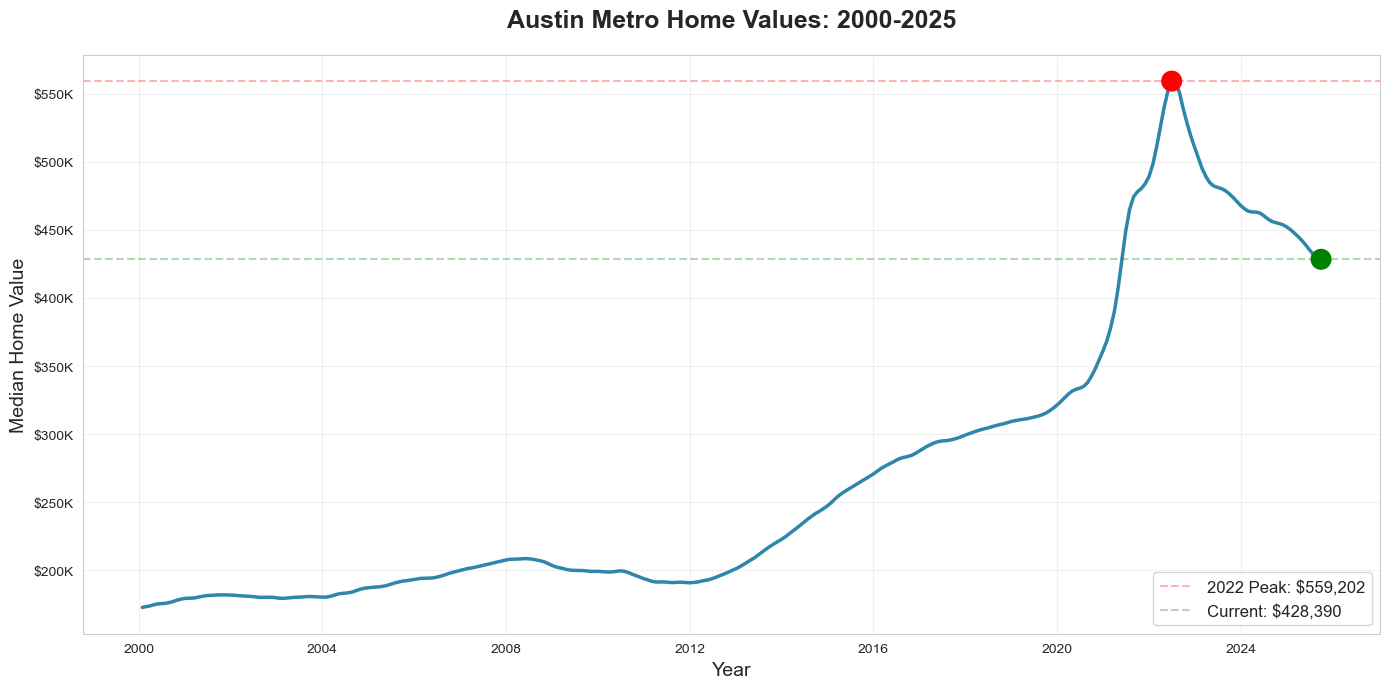

Peak price: $559,202 (June 2022)
Current price: $428,390 (September 2025)
Distance from peak: -23.4%


In [29]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Get Austin metro data (from original Zillow metro dataset)
austin_metro = df_home_values[df_home_values['RegionName'].str.contains('Austin, TX', na=False)].iloc[0]

# Extract time series data
date_cols = [col for col in austin_metro.index if col.startswith('20')]
dates = pd.to_datetime(date_cols)
prices = austin_metro[date_cols].values

# Create the plot
plt.figure(figsize=(14, 7))
plt.plot(dates, prices, linewidth=2.5, color='#2E86AB')

# Add key markers
peak_idx = prices.argmax()
peak_date = dates[peak_idx]
peak_price = prices[peak_idx]

current_price = prices[-1]
current_date = dates[-1]

plt.scatter([peak_date, current_date], [peak_price, current_price],
            s=200, zorder=5, color=['red', 'green'])

plt.axhline(y=peak_price, color='red', linestyle='--', alpha=0.3, label=f'2022 Peak: ${peak_price:,.0f}')
plt.axhline(y=current_price, color='green', linestyle='--', alpha=0.3, label=f'Current: ${current_price:,.0f}')

# Formatting
plt.title('Austin Metro Home Values: 2000-2025', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Median Home Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Format y-axis as currency
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.savefig('../visuals/austin_metro_price_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Peak price: ${peak_price:,.0f} ({peak_date.strftime('%B %Y')})")
print(f"Current price: ${current_price:,.0f} ({current_date.strftime('%B %Y')})")
print(f"Distance from peak: {((current_price / peak_price) - 1) * 100:.1f}%")


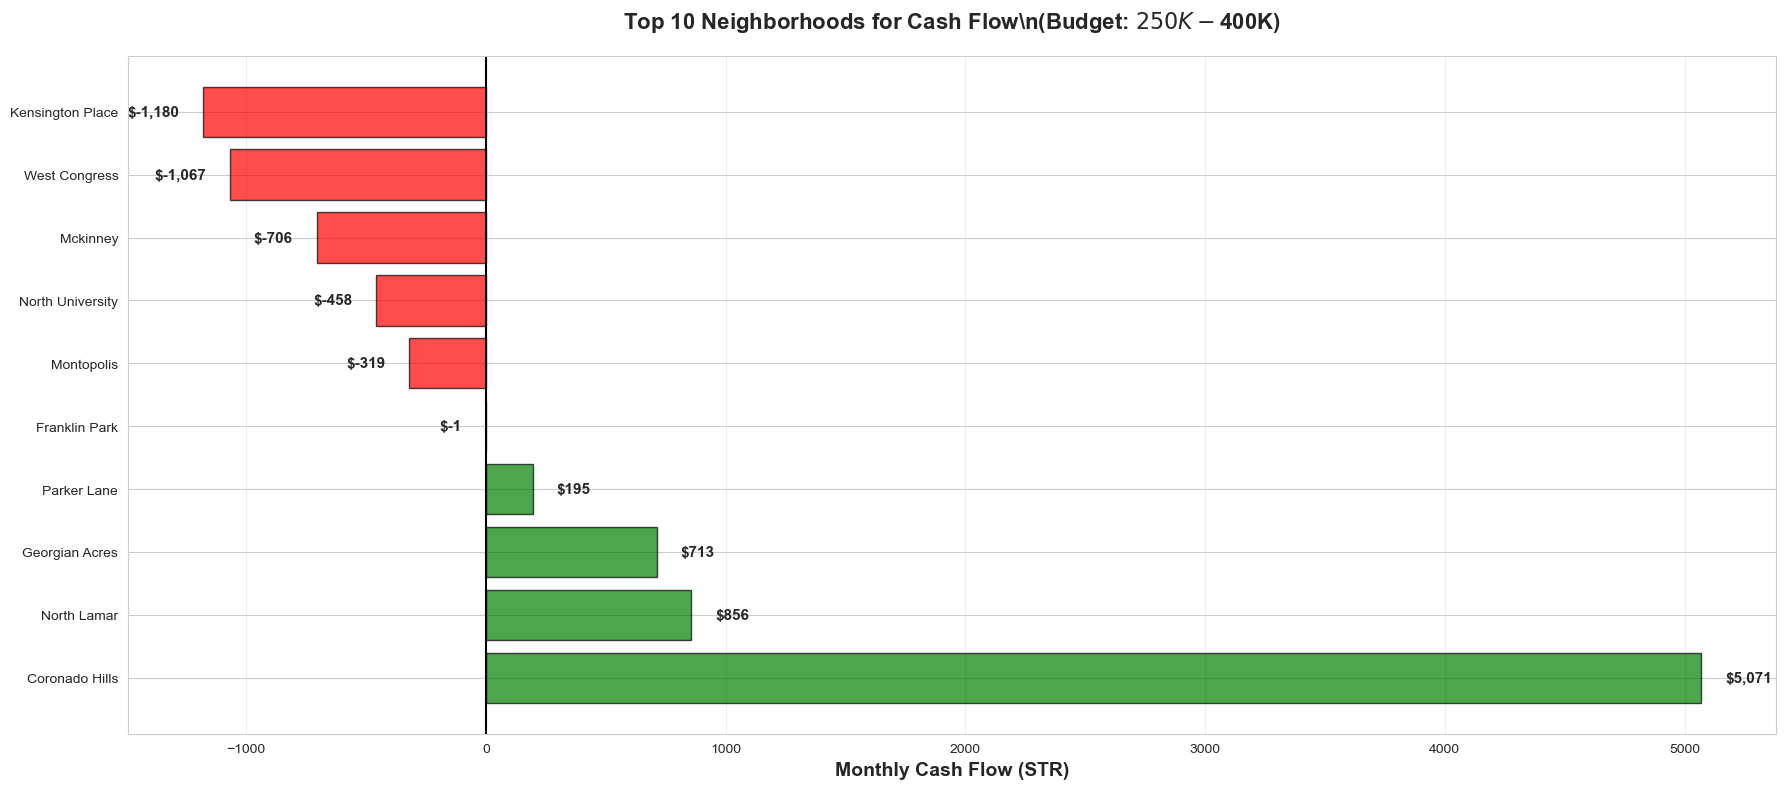

Top 3 Cash Flow Neighborhoods:
1. Coronado Hills: $5,071/month
2. North Lamar: $856/month
3. Georgian Acres: $713/month


In [34]:
# Get top 10 neighborhoods for cash flow strategy (within budget)
budget_filtered = df_final[
    (df_final['current_price_2025'] >= 250000) &
    (df_final['current_price_2025'] <= 400000)
]

top_10_cashflow = budget_filtered.sort_values('str_monthly_cash_flow', ascending=False).head(10)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(18, 8))

# Color bars: green for positive cash flow, red for negative
colors = ['green' if x > 0 else 'red' for x in top_10_cashflow['str_monthly_cash_flow']]

bars = ax.barh(top_10_cashflow['RegionName'],
               top_10_cashflow['str_monthly_cash_flow'],
               color=colors, alpha=0.7, edgecolor='black')

# Add value labels
for i, (idx, row) in enumerate(top_10_cashflow.iterrows()):
    value = row['str_monthly_cash_flow']
    ax.text(value + 100 if value > 0 else value - 100, i,
            f'${value:,.0f}',
            va='center', ha='left' if value > 0 else 'right',
            fontweight='bold', fontsize=11)

# Formatting
ax.axvline(x=0, color='black', linewidth=1.5)
ax.set_xlabel('Monthly Cash Flow (STR)', fontsize=14, fontweight='bold')
ax.set_title('Top 10 Neighborhoods for Cash Flow\\n(Budget: $250K-$400K)',
             fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../visuals/top_neighborhoods_cashflow.png', dpi=300, bbox_inches='tight')
plt.show()

print("Top 3 Cash Flow Neighborhoods:")
for i, (idx, row) in enumerate(top_10_cashflow.head(3).iterrows(), 1):
    print(f"{i}. {row['RegionName']}: ${row['str_monthly_cash_flow']:,.0f}/month")


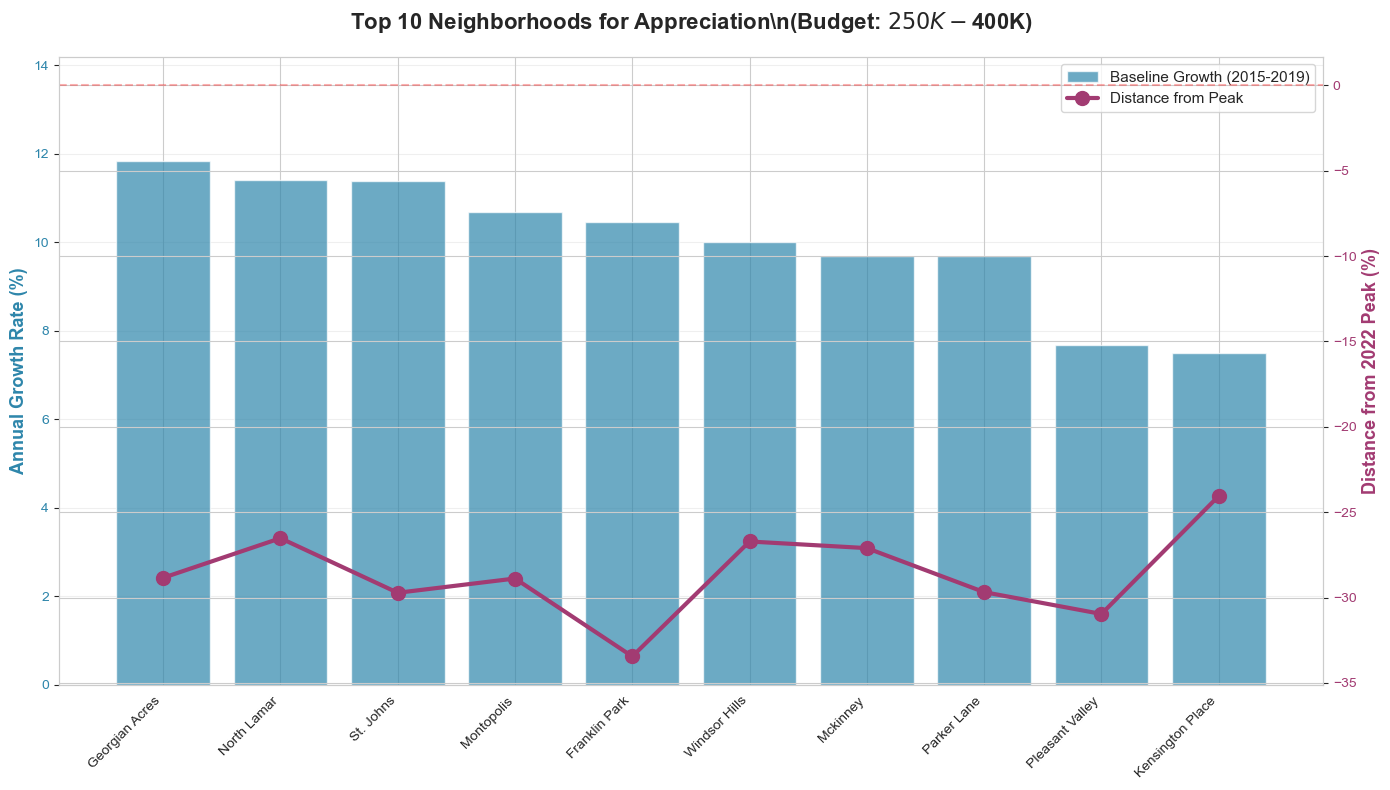


Key Insight:
Best appreciation neighborhoods are 29% below peak on average
Average historical growth: 10.0% annually


In [31]:
# Get top 10 neighborhoods for appreciation strategy (within budget)
top_10_appreciation = budget_filtered.sort_values('baseline_cagr', ascending=False).head(10)

# Create dual-axis chart: baseline CAGR vs distance from peak
fig, ax1 = plt.subplots(figsize=(14, 8))

x = range(len(top_10_appreciation))
neighborhoods = top_10_appreciation['RegionName'].values

# Plot baseline CAGR (left axis)
color1 = '#2E86AB'
ax1.bar(x, top_10_appreciation['baseline_cagr'], alpha=0.7, color=color1, label='Baseline Growth (2015-2019)')
ax1.set_ylabel('Annual Growth Rate (%)', fontsize=13, fontweight='bold', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0, max(top_10_appreciation['baseline_cagr']) * 1.2)

# Plot distance from peak (right axis)
ax2 = ax1.twinx()
color2 = '#A23B72'
ax2.plot(x, top_10_appreciation['distance_from_peak'],
         marker='o', linewidth=3, markersize=10, color=color2, label='Distance from Peak')
ax2.set_ylabel('Distance from 2022 Peak (%)', fontsize=13, fontweight='bold', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.3)

# Formatting
ax1.set_xticks(x)
ax1.set_xticklabels(neighborhoods, rotation=45, ha='right')
ax1.set_title('Top 10 Neighborhoods for Appreciation\\n(Budget: $250K-$400K)',
              fontsize=16, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig('../visuals/top_neighborhoods_appreciation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nKey Insight:")
print(f"Best appreciation neighborhoods are {abs(top_10_appreciation['distance_from_peak'].mean()):.0f}% below peak on average")
print(f"Average historical growth: {top_10_appreciation['baseline_cagr'].mean():.1f}% annually")


In [32]:
# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("="*70)
print("ANALYSIS SUMMARY")
print("="*70)

print(f"\nDatasets Analyzed:")
print(f"  • Zillow Home Values: {len(df_austin_neighborhoods)} Austin neighborhoods")
print(f"  • Airbnb Listings: {len(df_airbnb):,} properties")
print(f"  • Merged Dataset: {len(df_final)} neighborhoods with reliable data")

print(f"\nPrice Range:")
print(f"  • Minimum: ${df_final['current_price_2025'].min():,.0f}")
print(f"  • Median: ${df_final['current_price_2025'].median():,.0f}")
print(f"  • Maximum: ${df_final['current_price_2025'].max():,.0f}")

print(f"\nCash Flow Potential (STR):")
print(f"  • Positive cash flow neighborhoods: {len(df_final[df_final['str_monthly_cash_flow'] > 0])}")
print(f"  • Best performer: {df_final.loc[df_final['str_monthly_cash_flow'].idxmax(), 'RegionName']}")
print(f"    → ${df_final['str_monthly_cash_flow'].max():,.0f}/month")

print(f"\nAppreciation Potential:")
print(f"  • Average baseline growth (2015-2019): {df_final['baseline_cagr'].mean():.2f}% annually")
print(f"  • Top growth neighborhood: {df_final.loc[df_final['baseline_cagr'].idxmax(), 'RegionName']}")
print(f"    → {df_final['baseline_cagr'].max():.2f}% annually")

print(f"\nMarket Context:")
print(f"  • Average distance from 2022 peak: {df_final['distance_from_peak'].mean():.1f}%")
print(f"  • Neighborhoods still below peak: {len(df_final[df_final['distance_from_peak'] < 0])}/56")

print("\n" + "="*70)


ANALYSIS SUMMARY

Datasets Analyzed:
  • Zillow Home Values: 185 Austin neighborhoods
  • Airbnb Listings: 15,187 properties
  • Merged Dataset: 56 neighborhoods with reliable data

Price Range:
  • Minimum: $224,168
  • Median: $541,689
  • Maximum: $2,180,725

Cash Flow Potential (STR):
  • Positive cash flow neighborhoods: 8
  • Best performer: Coronado Hills
    → $5,071/month

Appreciation Potential:
  • Average baseline growth (2015-2019): 6.63% annually
  • Top growth neighborhood: Georgian Acres
    → 11.83% annually

Market Context:
  • Average distance from 2022 peak: -25.8%
  • Neighborhoods still below peak: 56/56

